# About the Project

## The Customer

The customer is a fashion retailer with numerous stores across Germany. It collected data of articles that have been on sale over a period of time and now wants to do some analysis on the basis of that data.

## The Task

The fashion retailer wants to use the data for:

  * Sales volume predictions for articles 
  * Optimal price determination of new articles on market launch
  * Inventory calculation 
  * General predictions and strategic decision making


Such predictions need a population, which serves as a basis for statistical calculations.
Predicting the sales of a specific article on basis of the whole assortment would be too imprecise.
The mean variation is too high, hence the quality of the prediction would be very low.
The amount and variety of articles allows to refer to a more representative population. For an optimal prediction quality, the population should be as big as possible and its mean variation as small as possible.

It is possible to create such a population, by grouping articles with similar characteristic attributes together. This can be realized through a clustering algorithm.

## The Goal

The overall goal of the project is to develop a clustering algorithm, that provide meaningful article clusters. The algorithm should provide reasonable results and build on statistically verified methods. The special challenge of the clustering algorithm is:

- Clusters should be characterized by article attributes (e.g. brand, color, ..)
- Clusters should be formed according to similar behavior in number of articles sold, revenue or sales-quotas over time

In clustering the distance (similarity) and the characterizing attributes build on the same features. This is not the case here. Thus, we can not use existing packages for categorical-, nor time-series clustering, because each would contradict one of the constraints above. A further requirement is, that each article has to be assigned to a cluster.

# Data Introduction

First, we want to give an overview of the provided data. Therefore, we have a look at the raw dataset and 
do some visualization for a better understanding of the data.

In [24]:
# Needed imports for the rest of the notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Our developed package 'tailor'
import tailor
from tailor import data
from tailor.clustering import *
from tailor.visualization import *

## Example of the Raw Data

In [2]:
raw_data = data.load_csv()
raw_data.head(10)

,article_id,transaction_date,markdown_start_date,markdown_end_date,original_price,sells_price,discount,markdown,article_count,season,brand,color,stock_total,avq,Abteilung,WHG,WUG,time_on_sale,revenue
0,900001,2014-03-27,2013-10-18,2014-05-31,59.95,53.95,6.00,0.0,2,Sommer,Fimmilena,mittelbraun,1499,0.133422,Abteilung005,WHG021,WUG073,0,107.90
1,900001,2014-03-28,2013-10-18,2014-05-31,59.95,59.95,0.00,0.0,2,Sommer,Fimmilena,mittelbraun,1499,0.266845,Abteilung005,WHG021,WUG073,1,119.90
2,900001,2014-03-29,2013-10-18,2014-05-31,59.95,59.95,0.00,0.0,3,Sommer,Fimmilena,mittelbraun,1499,0.466978,Abteilung005,WHG021,WUG073,2,179.85
3,900001,2014-03-31,2013-10-18,2014-05-31,59.95,59.55,0.40,0.0,5,Sommer,Fimmilena,mittelbraun,1499,0.800534,Abteilung005,WHG021,WUG073,4,297.75
4,900001,2014-04-01,2013-10-18,2014-05-31,59.95,59.95,0.00,0.0,6,Sommer,Fimmilena,mittelbraun,1499,1.200801,Abteilung005,WHG021,WUG073,5,359.70
5,900001,2014-04-02,2013-10-18,2014-05-31,59.95,59.95,0.00,0.0,4,Sommer,Fimmilena,mittelbraun,1499,1.467645,Abteilung005,WHG021,WUG073,6,239.80
6,900001,2014-04-03,2013-10-18,2014-05-31,59.95,58.59,1.36,0.0,4,Sommer,Fimmilena,mittelbraun,1499,1.734490,Abteilung005,WHG021,WUG073,7,234.36
7,900001,2014-04-04,2013-10-18,2014-05-31,59.95,59.95,0.00,0.0,7,Sommer,Fimmilena,mittelbraun,1499,2.201468,Abteilung005,WHG021,WUG073,8,419.65
8,900001,2014-04-05,2013-10-18,2014-05-31,59.95,59.95,0.00,0.0,13,Sommer,Fimmilena,mittelbraun,1499,3.068712,Abteilung005,WHG021,WUG073,9,779.35
9,900001,2014-04-06,2013-10-18,2014-05-31,59.95,59.95,0.00,0.0,2,Sommer,Fimmilena,mittelbraun,1499,3.202135,Abteilung005,WHG021,WUG073,10,119.90


## Feature Overview

  * *markdown* is constant for *article_id* and *transaction_date* between *markdown_start_date* and *markdown_end_date*
  * *original_price* is constant for *article_id*
  * *sells_price* is the actual price paid by the customer
  * *sells_price*, *discount* and *markdown* are of the unit [Euro/article]
  * *article_count* denominates the number of sold articles
  * *discount* = *original_price* - *markdown* - *sells_price*
  * *avq* is the current stock divided by *stock_total*

In [3]:
pd.options.display.float_format = "{:.2f}".format
raw_data.describe(include=np.number)

,article_id,original_price,sells_price,discount,markdown,article_count,stock_total,avq,time_on_sale,revenue
count,1131329.00,1131329.00,1131329.00,1131329.00,1131329.00,1131329.00,1131329.00,1131329.00,1131329.00,1131329.00
mean,904359.27,51.33,43.87,2.58,4.88,8.52,2162.84,30.12,87.38,317.27
std,2521.36,22.19,20.50,5.73,9.43,10.84,1960.91,22.89,50.69,385.77
min,900001.00,9.95,-47.96,-99.96,-19.00,1.00,106.00,0.00,0.00,-47.96
25%,902176.00,35.95,29.34,0.00,0.00,2.00,910.00,10.24,44.00,86.28
50%,904338.00,49.95,39.95,0.28,0.00,5.00,1737.00,26.28,86.00,190.95
75%,906569.00,64.95,58.02,2.50,10.00,11.00,2956.00,46.08,130.00,397.12
max,908708.00,179.95,199.91,129.96,90.00,281.00,36396.00,100.25,181.00,13403.60


## Consistency Checks

#### Check if the dataset contains null values

In [4]:
raw_data.isna().values.any()

False

We are lucky, there are no null values in the dataset!

#### Detect how many articles are contained in the dataset

In [5]:
len(raw_data['article_id'].unique())

8708

#### Get the maximum timespan the articles have been on sale

In [6]:
raw_data['time_on_sale'].max()

181

This means we will be comparing sales of articles over a course of 182 consecutive days. Counting starts at day 0.


#### Check how many articles don't have values defined for the full range of the 182 days

In [7]:
tos = raw_data.groupby('article_id').apply(lambda x: x.time_on_sale.nunique())
len(tos[tos == 182])

0

After all there are a lot of missing data, but they were hidden. We do not see a single article has data for each of the 182 days they have been on sale! This problem has to be addressed in a later step.

## Visualization of the Raw Data

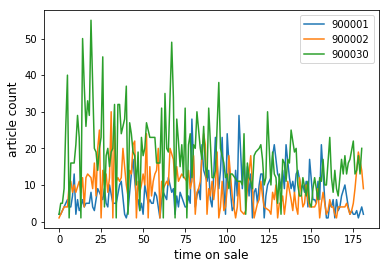

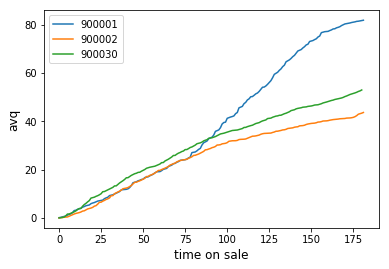

In [8]:
plot_articles(raw_data, [900001, 900002, 900030], 'article_count');
plot_articles(raw_data, [900001, 900002, 900030], 'avq');

# Data Processing

For the next step, we process the raw data into a consistent and suitable dataset.
Therefore, we perform the following steps:

1. __Drop invalid rows which do not make sense (e.g. negative sells price)__


2. __Transform the different columns into specific datatypes:__
  * *article_id* = category
  * *transaction_date* = datetime
  * *markdown_start_date* = datetime
  * *markdown_end_date* = datetime
  * *all other columns* with datatype object = category
  
  
3. __Build new features__
  * Build a new column and calculate the weeks an article has been on sale (weeks_on_sale)
  * Rebuild the season column with the season of the first transaction
  
  
4. __Group time on sale by weeks__
  * Replace the time_on_sale values through weeks on sale
  * As a result, we consider every article on a weekly basis instead of a daily basis
  
  
5. __Fill missing values__
  * As we found out before, not all articles have sales on each day for the consecutive 182 days. Therefore, we add extra rows with zero values for the missing *time_on_sales* values
  
6. __Data normalization__
  * Come up with it here are in a later paragraph?

# Data Exploration

Next, we want to give an overview of the processed data and illustrate our procedure. We will have a look at the processed dataset, do some visualizations and explanations for a better and deeper understanding of the data.

## Example of the Processed Data

In [9]:
df = data.load_data()
df.head(10)

,article_id,time_on_sale,original_price,markdown,stock_total,article_count,revenue,avq,sells_price,discount,brand,color,Abteilung,WHG,WUG,month,season,norm_article_count,norm_avq,norm_revenue
0,900001,0,59.95,0.00,1499,22,1304.90,0.72,59.31,0.64,Fimmilena,mittelbraun,Abteilung005,WHG021,WUG073,March,Spring,1.04,0.03,1.86
1,900001,1,59.95,0.00,1499,39,2332.61,3.10,59.81,0.14,Fimmilena,mittelbraun,Abteilung005,WHG021,WUG073,March,Spring,1.84,0.11,3.32
2,900001,2,59.95,0.00,1499,32,1891.40,5.30,59.11,0.84,Fimmilena,mittelbraun,Abteilung005,WHG021,WUG073,March,Spring,1.51,0.19,2.69
3,900001,3,59.95,0.00,1499,27,1596.69,7.20,59.14,0.81,Fimmilena,mittelbraun,Abteilung005,WHG021,WUG073,March,Spring,1.27,0.26,2.27
4,900001,4,59.95,0.00,1499,34,2026.30,9.34,59.60,0.35,Fimmilena,mittelbraun,Abteilung005,WHG021,WUG073,March,Spring,1.60,0.34,2.88
5,900001,5,59.95,0.00,1499,27,1594.66,11.67,59.06,0.89,Fimmilena,mittelbraun,Abteilung005,WHG021,WUG073,March,Spring,1.27,0.43,2.27
6,900001,6,59.95,0.00,1499,53,3159.35,14.45,59.61,0.34,Fimmilena,mittelbraun,Abteilung005,WHG021,WUG073,March,Spring,2.50,0.53,4.50
7,900001,7,59.95,0.00,1499,33,1946.54,16.86,58.99,0.96,Fimmilena,mittelbraun,Abteilung005,WHG021,WUG073,March,Spring,1.55,0.61,2.77
8,900001,8,59.95,0.00,1499,35,2096.92,19.16,59.91,0.04,Fimmilena,mittelbraun,Abteilung005,WHG021,WUG073,March,Spring,1.65,0.70,2.99
9,900001,9,59.95,12.00,1499,37,2188.15,21.77,59.14,-11.19,Fimmilena,mittelbraun,Abteilung005,WHG021,WUG073,March,Spring,1.74,0.79,3.12


In [10]:
df.dtypes

article_id            category
time_on_sale             int64
original_price         float64
markdown               float64
stock_total              int64
article_count            int64
revenue                float64
avq                    float64
sells_price            float64
discount               float64
brand                 category
color                 category
Abteilung             category
WHG                   category
WUG                   category
month                 category
season                category
norm_article_count     float64
norm_avq               float64
norm_revenue           float64
dtype: object

## Visualization of the Processed Data

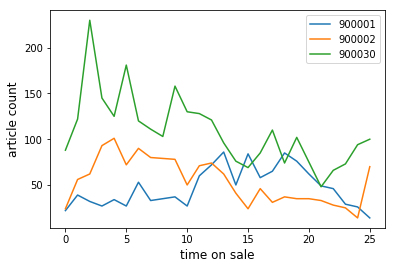

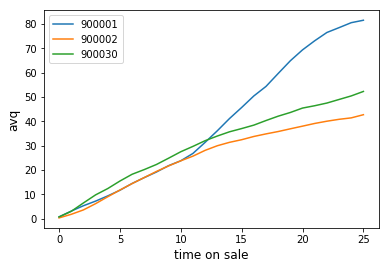

In [11]:
plot_articles(df, [900001, 900002, 900030], 'article_count');
plot_articles(df, [900001, 900002, 900030], 'avq');

In comparison to the raw data, you can see that the graphs no longer looks that messy. It is easier to identify which graphs are similar. Moreover we see that we removed seasonal effects by grouping the daily sales to weeks.

## Inter-Feature Variance

Remember that we want to identify a (sub-)population of similar articles that we can use for prediction or further analysis. 

For an optimal prediction quality this group has to be:

- As similar as possible (Small variance)
- As big as possible (Large sample size)

We want to create such a group by:

1. Splitting the population into groups where the (article-) characteristics of a feature behave differently. (E.g. blue articles are different from red articles)
2. Grouping (article-)characteristics together that behave similarly. (E.g. blue and grey articles are similar to each other)

Here the **feature** is *color*, and the **characteristics** are *blue*, *grey* and *red*.

To find features, where this is easily possible, we will look at the **inter-feature variance**. The **inter-feature variance** measures the variance of the characteristics within a feature. A high **inter-feature variance** indicates differently behaving characteristics.

Next, we will look at the graphs some features to get an idea, how the different characteristics are distributed.

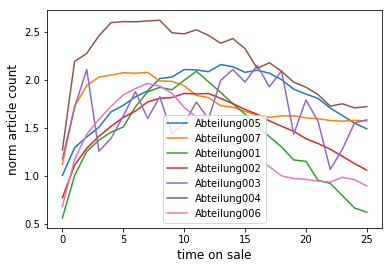

In [12]:
plot_feature_characteristics(df, 'Abteilung', 'norm_article_count');

This graph visualizes the inter-feat variance of the feature 'Abteilung'. We can see that all curves are quite different from each other. That indicates that the individual characteristics should be treated individually. (Form an own cluster) 

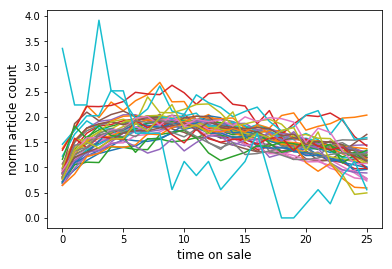

In [13]:
plot_feature_characteristics(df, 'color', 'norm_article_count', legend=False);

This graph visualizes the inter-feat variance of the feature 'color'. Each curve represents the averaged sells of articles with the same color. We can see that quite a few curves in the middle look very similar, while at the top and bottom are "far away" from the others. We can assume that the similar colors-curves in the middle should be treated the same (form a cluster together) and the curves which look different should be treated individually.

Indeed, calculating the *inter-feat variances* of the two features clearly show that 'Abteilung' has a much larger variance then 'color', thus the feature 'Abteilung' is more interesting to consider for clustering.

In [14]:
clustering.inter_feat_variance(df, clustering.distance.absolute, 'Abteilung', 'norm_article_count')

0.05412213540691129

In [15]:
clustering.inter_feat_variance(df, clustering.distance.absolute, 'color', 'norm_article_count')

0.014113547960484012

# The Clustering Algorithm

## General

The general idea of the clustering algorithm is to recursively split the article population into the characteristics of each feature. After every step, merge "similar" characteristics together to clusters. This is a way of hierarchical clustering: With each considered feature the number of clusters increases and the size of the clusters grows smaller.


In the end we will have clusters that look like this:

* Level 1
    * __Cluster 1__:  
        * _Brand_: Adidas

    * __Cluster 2__:  
        * _Brand_: Nike, Rebook 
* Level 2
    * __Cluster 1.1__:  
        * _Brand_: Adidas
        * _Color_: blue, red 
    * __Cluster 1.2__:  
        * _Brand_: Adidas
        * _Color_: green
    * __Cluster 2.1__:
        * _Brand_: Nike, Rebook
        * _Color_: red
    * __Cluster 2.2__:  
        * _Brand_: Nike, Rebook
        * _Color_: blue, green
* Level 3:
    * __Cluster 1.1.1__:  
        * _Brand_: Adidas
        * _Color_: blue, red
        * _Season_: autumn 
    * ...
    
Note: The features don't have to be split the same way across all cluster. See e.g. _Cluster 1.1_ vs. _Cluster 2.1_.  The feature color has been split differently. E.g. "Red and blue Adidas shoes are similar, but red Nikes and Rebooks and not similar to blue Nikes and Rebooks"

The challenge is a) to rank the features in the best order we want to consider them (e.g. first _Brand_ then _Color_) and b) find similar behaving characteristics (e.g. blue and red Adidas are similar).

## Similarity Measure

Each clustering algorithm needs to define a similarity measure, also called "distance", to cluster similar items together. In our case "similar" articles are articles, that showed similar selling behavior while being on sale in the shops of the customer. The dataset yields measures for the number of articles sold over time (*article count*) the generated *revenue* and the sales quota in comparison to the stock (_avq_, _Abverkaufsquote_). So in the use-case of our customer similar articles are the ones that have a similar curve of *revenue*, *article_count* or *avq* over time.

#### When we look at two pairs of articles we can see that the distance is lower when the curves are closer to each other

distance:  23.884615384615383


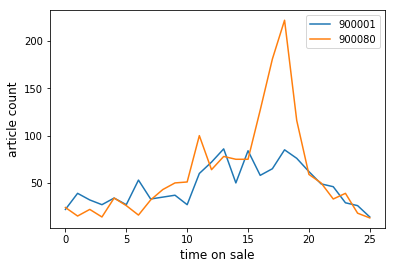

In [16]:
plot_articles(df, [900001, 900080], 'article_count');
a = df.loc[df.article_id == 900001].set_index('time_on_sale')['article_count']
b = df.loc[df.article_id == 900080].set_index('time_on_sale')['article_count']
print("distance: ", clustering.distance.absolute(a,b))

distance:  32.5


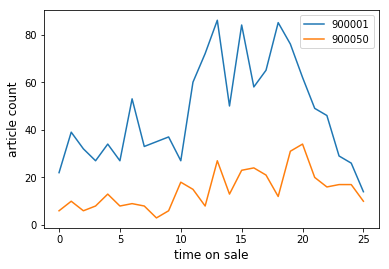

In [17]:
plot_articles(df, [900001, 900050], 'article_count');
a = df.loc[df.article_id == 900001].set_index('time_on_sale')['article_count']
b = df.loc[df.article_id == 900050].set_index('time_on_sale')['article_count']
print("distance: ", clustering.distance.absolute(a,b))

### Normalization

One problem remains: If we look at the at the upper graph we can see that the two curves are far apart, but they have a somehow similar shape. Here it is crucial that we __normalize__ the curves. Normalized values allow the comparison of corresponding normalized values for different observations.

We chose to normalize the article curves with the **Standardized Moment**, the process is also called **standardization**. This kind of normalization is typically a division by the *standard deviation*. This has the advantage that such normalized moments differ only in other properties than variability, which facilitates e.g. comparison of shape.

If we look at the same articles, but plot and calculate the distance with the normalized values we can see that the 
two articles are now much closer.The distance measure is now implicitly taking the *shape* into account, when calculating the absolute distance between the normalized values.

distance:  0.7963159525312393


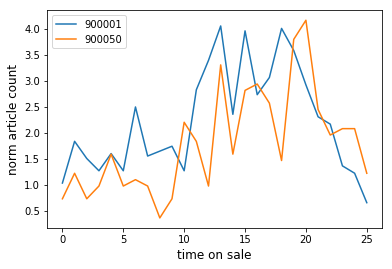

In [18]:
plot_articles(df, [900001, 900050], 'norm_article_count');
a = df.loc[df.article_id == 900001].set_index('time_on_sale')['norm_article_count']
b = df.loc[df.article_id == 900050].set_index('time_on_sale')['norm_article_count']
print("distance: ", clustering.distance.absolute(a,b))

## Outline of the Algorithm

Remember we are searching article groups, characterized by their attributes (color, brand, etc..) that are similar to each other. We previously defined similarity, showed the structure of the resulting clusters, and discussed the categorical as well as the time-series part of the clustering. Now we will illustrate the top-level steps the clustering algorithm actually does.


```python
# 1. Get a list of ranked features (color, brand, etc..) 
#    according to their inter_feature score
features =  rank_features()

# Repeat until all features considered
for f in features:
    # 2. Split feature characteristics into separate clusters
    split_features()
   
    # 3. Merge similar characteristics together into a cluster. Merge when the distance
    #    between two cluster is less then a 'similarity_threshold' 
    merge_close_clusters()
    
    # 4. Merge clusters that are below the min_cluster_size into the closest cluster
    merge_min_clusters()
    
    # 5. When no new clusters resulted from the considered feature finish the clustering
    #    (e.g. all new clusters were too small)
    if no_new_clusters:
        break
```

In words, we are considering every feature, ranked by its variance score. The features characteristics form a cluster, which then get merged with similar characteristics (Remember we want the clusters to be as similar as possible). The merging is going to happen more frequently towards the end of the `ranked_feature list`, since the feature characteristics are closer to another (low variance). Furthermore we are looking at the size of the clusters, and merge clusters which are too small (Remember we want the clusters to be as big as possible). The `min_cluster_size` and the `similarity_threshold` are parameters and can be set according to the customers preferences. Of course there is always a trade-of between similarity and size of a cluster.

## Hierarchical Component

(Here some kind of visualization of the clustering process would be cool)

# Results and Evaluation

To discuss the results we will pick out an potential use-case of a customer and go through the whole clustering process. 

Assuming we are a fashion retailer and want to introduce a new special edition shoe into our shops. Beforehand, we want to know how much **revenue** this article is likely going to generate and how the **revenue curve** will likley look like over the course of the 26 weeks this special shoe is available in our shops. In order to let our data science team do all the prediction work, we have to give them a reference population of shoes that are similar to our new special edition shoe. Luckily we have paid the smart guys from tailorit to find this reference population, by using a **cluster analysis**. The smart guys from tailorit have developed a clustering package called **tailor** which they going to use for the analysis.

#### Define The Use Case

In [19]:
# Use standardized revenue as measure for clustering
target_value = 'norm_revenue'
# We want to observe all features available
features = ['color', 'brand', 'Abteilung', 'WHG', 'WUG', 'season', 'month']
# Use absolute distance between the curves as similarity measure
distance_measure = clustering.distance.absolute

In [25]:
ranking.rank_features(df, distance_measure, features, target_value)

,feature,variance,num_characteristics
4,WUG,0.18,152
3,WHG,0.12,43
1,brand,0.11,75
6,month,0.11,12
2,Abteilung,0.06,7
5,season,0.05,4
0,color,0.02,40


# Outlook and Discussion